# Use the parametric KdV for prediction at F-block site

In [1]:
# Load the libraries
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart

from glob import glob

In [2]:
%matplotlib inline

# Load the tidal amplitude data

In [3]:
# Load the tidal amplitude
##########
# Inputs
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

time = TimeVector('20160501.000000','20170501.000000',3600)

basetime = datetime(2007,1,1)
##########
# Extract the tidal height for the whole period
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

# Manually compute the amp and phase that includes the nodal corrections
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()

beta_s

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


array([ 1.28147164, -0.16830373, -0.37533113,  0.61863875,  0.20558667,
        0.0877764 ,  0.03537366, -0.15298557, -0.23119784,  0.05434594,
       -0.02072033,  0.131407  , -0.07917434, -0.00338273, -0.02555615,
        0.0160887 ])

F_Block_2007_CM04
F_Block_2008a_CM04
F_Block_2008b_CM04
F_Block_2009a_CM04
F_Block_2009b_CM04


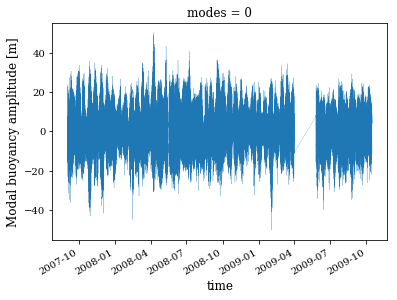

In [4]:
# Load the observed amplitude and stratification data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
mode = 0
###########


# Merge the two
with Dataset(ncfile) as nc:
    for gg in nc.groups.keys():
        print(gg)
    
ds0 = xr.open_dataset(ncfile,group='F_Block_2007_CM04')
ds1 = xr.open_dataset(ncfile,group='F_Block_2008a_CM04')
ds2 = xr.open_dataset(ncfile,group='F_Block_2008b_CM04')
ds3 = xr.open_dataset(ncfile,group='F_Block_2009a_CM04')
ds4 = xr.open_dataset(ncfile,group='F_Block_2009b_CM04')



A_n = xr.concat([ds0['A_n'][:,mode],
    ds1['A_n'][:,mode],ds2['A_n'][:,mode],\
                ds3['A_n'][:,mode],ds4['A_n'][:,mode]], dim='time')

c_n = xr.concat([ds0['cn'][:,mode],
    ds1['cn'][:,mode],ds2['cn'][:,mode],\
                ds3['cn'][:,mode],ds4['cn'][:,mode]], dim='timeslow')

r10_n = xr.concat([ds0['r10'][:,mode],
    ds1['r10'][:,mode],ds2['r10'][:,mode],\
                ds3['r10'][:,mode],ds4['r10'][:,mode]], dim='timeslow')

alpha_n = -2*c_n*r10_n
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')



# Create a time series of single days with the max amplitude 
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')
#time = time1.append(time2)

time = pd.date_range('2007-09-1','2009-10-1') 

plt.figure()
A_n.plot(lw=0.2)

In [5]:
# Find the A_max over one day blocks
def maximum_amplitude_finder(amp_signal):
    if np.shape(amp_signal)[0] == 0:
        return 0,-1
    
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

Amax_all = []
Amax_time = []
for t1 in time:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    if tidx == -1:
        tmax = t1
    else:
        tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
        
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

Text(0.5, 1.0, '')

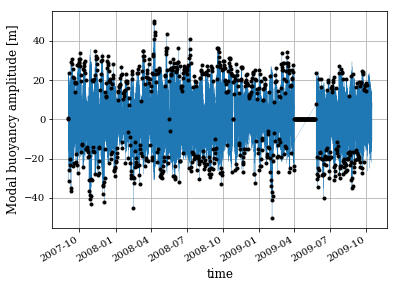

In [12]:
plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A.time, ds_A, 'k.')
plt.grid(b=True)
plt.title('')

# Load the a0 beta fit parameters



In [7]:

inputh5 = '../inputs/a0_betas_Crux.h5'
f = h5py.File(inputh5,'r')
a0_beta = f['data/a0-beta'][:]
f.close()

a0_beta.shape

(500, 2)

# Define some functions

In [8]:
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    zeros = np.zeros
    cos = np.cos
    sin = np.sin
    
    result = zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*cos(ff[ii] * t) + beta_s[2*ii+1]*sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

def calc_Ls(a0, omega, c, alpha):
    return c*c / (a0*omega*alpha)

def calc_Lhat(a0, omega, c, alpha, L):
    return calc_Ls(a0, omega, c, alpha) / L

def calc_zetahat(beta, omega, t):
    return sine_model_envelope(beta, omega, t)
    
def calc_a0(beta, zetahat):
    return beta[0] + beta[1]*zetahat


def calc_tlag(That, c, L):
    return L*That/c

def calc_tlag_nonlinear(That, c, L, alpha, A):
    c_nl = c+alpha*A
    return L*That/c_nl

def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1

    return Ahat

def compute_Ahat(beta, alpha, cn, L, zeta_s, omega, timeinsec, Ahat_args, That_args, omega0):

    nt = timeinsec.shape[0]
    That = np.zeros((nt,))
    a0 = np.zeros((nt,))
    
    for ii in range(6):

        # Compute the time lag
        #tlag = calc_tlag(That, cn, L)
        tlag = calc_tlag_nonlinear(That, cn, L, alpha, a0)

        # Compute a_0
        zetahat = calc_zetahat(zeta_s, omega, timeinsec - tlag)
        a0 = calc_a0(beta, zetahat)
        

        # Compute Ahat, Lhat
        Lhat = calc_Lhat(a0, omega0, cn, alpha, L)
        
        Ahat = calc_Ahat_quadratic(Lhat, Ahat_args)
        That = calc_That_quadratic(Lhat, That_args)
        
        Amax = a0*Ahat
        
    return Lhat, That, Ahat, a0
    

def compute_Amax(beta, alpha, cn, L, zeta_s, omega, timesec, Aargs, Targs, omega0):
    # Get alpha, c
    Lhat, That, Ahat, a0 = compute_Ahat(beta, alpha, cn, L, zeta_s, omega, \
                                        timesec, Aargs, Targs, omega0)

    return Ahat, a0

In [19]:
L = 0.6e5
alpha = alpha_n.sel(timeslow=time,method='nearest').values
cn = c_n.sel(timeslow=time,method='nearest').values

timeinsec = SecondsSince(time.values, basetime=basetime)

Ahat_args= (-2.68,-0.54)
That_args = (1.9,1.4,-0.34)
omega0 = 2*np.pi/(12.42*3600)

nsamples = a0_beta.shape[0]
nt = timeinsec.shape[0]

Apred = np.zeros((nsamples,nt))
for ii in range(nsamples):
    Ahat, a0 = compute_Amax(a0_beta[ii,:], alpha, cn, L, \
        beta_s, omega, timeinsec, Ahat_args, That_args, omega0)
    
    Apred[ii,:] = Ahat*a0
    

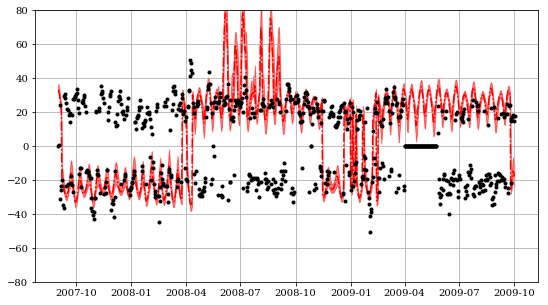

In [20]:
plt.figure(figsize=(9,5))

plt.plot(time, np.median(Apred,axis=0),'r-.')

plt.fill_between(time, np.min(Apred,axis=0),
            np.max(Apred,axis=0) ,color='r' ,alpha=0.5   )

plt.grid(b=True)
plt.ylim(-80,80)
plt.plot(ds_A.time, ds_A, 'k.')